# Dataset
- Consumer credit usage data that contains credit line granted to a customer, their
payment and balance history, demographics and their default status.
- Data Dictionary (below): Contains definition of all the attributes on .csv file.
# Questions
- Develop model(s) that predict customers’ probability of default.
- Outline the methodology used to develop and validate the model(s).
- Summarize key drivers and their relationship with default rate (Y).

# Data Dictionary
- X1: Amount of the given credit : it includes both the individual consumer credit and his/her family
(supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. Past monthly payment records (from April to September,
2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in
August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the
repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two
months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and
above. 
- X12-X17: Amount of bill statement. X12 = amount of bill statement in September, 2005; X13 =
amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment. X18 = amount paid in September, 2005; X19 = amount
paid in August, 2005; . . .;X23 = amount paid in April, 2005. 
- Y = default (Yes = 1, No = 0)


## Data overview

In [54]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

credit_data = pd.read_csv('./data.csv')
label_colm= 'Y'

In [55]:
credit_data.info()

credit_data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X1      30000 non-null  int64
 1   X2      30000 non-null  int64
 2   X3      30000 non-null  int64
 3   X4      30000 non-null  int64
 4   X5      30000 non-null  int64
 5   X6      30000 non-null  int64
 6   X7      30000 non-null  int64
 7   X8      30000 non-null  int64
 8   X9      30000 non-null  int64
 9   X10     30000 non-null  int64
 10  X11     30000 non-null  int64
 11  X12     30000 non-null  int64
 12  X13     30000 non-null  int64
 13  X14     30000 non-null  int64
 14  X15     30000 non-null  int64
 15  X16     30000 non-null  int64
 16  X17     30000 non-null  int64
 17  X18     30000 non-null  int64
 18  X19     30000 non-null  int64
 19  X20     30000 non-null  int64
 20  X21     30000 non-null  int64
 21  X22     30000 non-null  int64
 22  X23     30000 non-null  int64
 23  Y       300

X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
Y      0
dtype: int64

## Data visualization

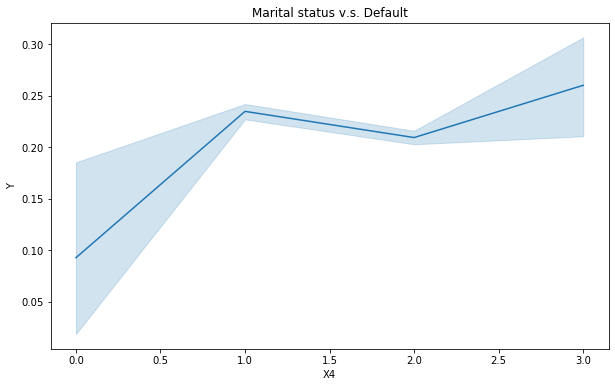

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.lineplot(x='X4', y='Y', data=credit_data)

plt.title('Marital status v.s. Default')
plt.show()

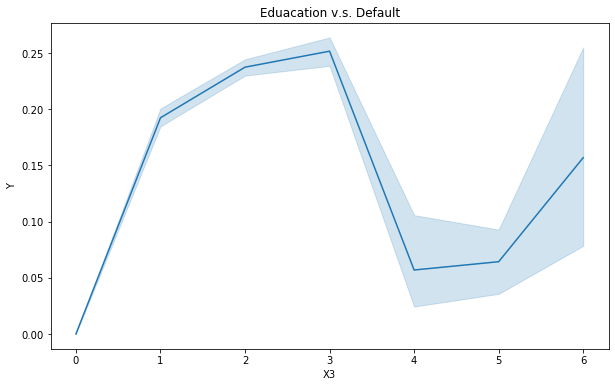

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.lineplot(x='X3', y='Y', data=credit_data)

plt.title('Eduacation v.s. Default')
plt.show()

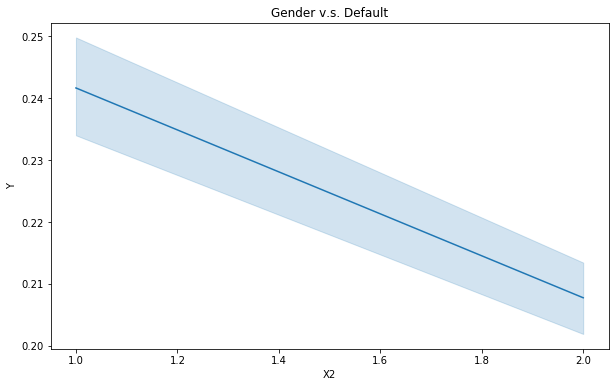

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.lineplot(x='X2', y='Y', data=credit_data)

plt.title('Gender v.s. Default')
plt.show()

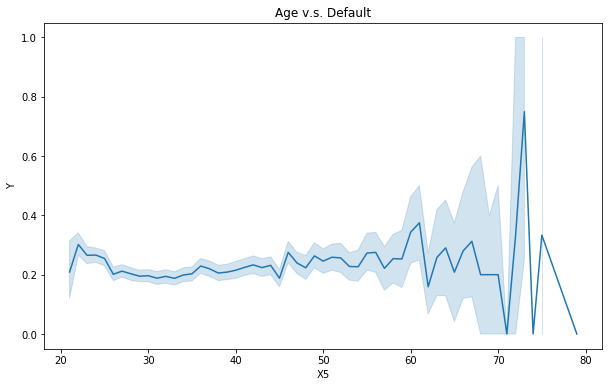

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.lineplot(x='X5', y='Y', data=credit_data)

plt.title('Age v.s. Default')
plt.show()

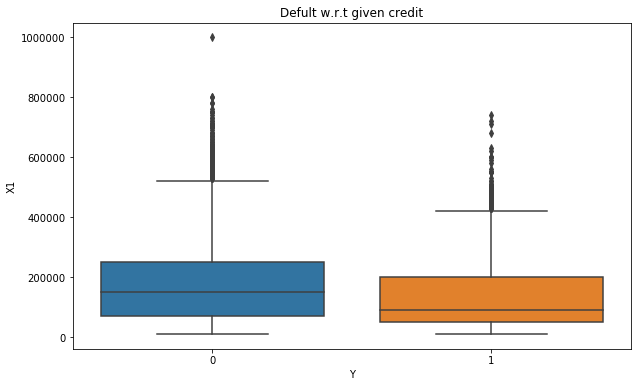

In [60]:
col1 = 'Y'
col2 = 'X1'
'''
Write your code below
'''
plt.figure(figsize=(10,6))
sns.boxplot(x=col1, y=col2, data=credit_data)
plt.title('Defult w.r.t given credit')
plt.show()


## Model 2: pyspark random forest classification

Load packages and data.csv, and other preps


In [61]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import pyspark
from pyspark.sql import SparkSession, Row
import os
conf = pyspark.SparkConf().setAll([('spark.master', 'local[*]'),
                                   ('spark.app.name', 'Weather Cluster Analysis')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

print (spark.version, pyspark.version.__version__)
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


2.4.5 2.4.5


In [62]:
# Load credit dataset
data_path ="/work/"# path 
df = "data.csv"
# read csv
df = spark.read.csv(df, header=True, inferSchema=True).cache()
# define feature columns
m = df.drop('Y')
feature_cols = m.columns

Take all the columns in **feature_cols** and concatenate their value into a vector format and create a new vector column named "featuresRandomForest" inside the DataFrame.


In [63]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="featuresRandomForest")
featuresdf = assembler.transform(df)
featuresdf.show(3)

featuresdf= featuresdf.withColumn("labelRandomForest",df["Y"] )

train_df, test_df = featuresdf.randomSplit((0.8,0.2),seed= 30)
test_df.count()/df.count()
print(test_df.count(),train_df.count())


+------+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+-----+-----+-----+----+----+----+----+----+----+---+--------------------+
|    X1| X2| X3| X4| X5| X6| X7| X8| X9|X10|X11|  X12|  X13|  X14|  X15|  X16|  X17| X18| X19| X20| X21| X22| X23|  Y|featuresRandomForest|
+------+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+-----+-----+-----+----+----+----+----+----+----+---+--------------------+
| 20000|  2|  2|  1| 24|  2|  2| -1| -1| -2| -2| 3913| 3102|  689|    0|    0|    0|   0| 689|   0|   0|   0|   0|  1|[20000.0,2.0,2.0,...|
|120000|  2|  2|  2| 26| -1|  2|  0|  0|  0|  2| 2682| 1725| 2682| 3272| 3455| 3261|   0|1000|1000|1000|   0|2000|  1|[120000.0,2.0,2.0...|
| 90000|  2|  2|  2| 34|  0|  0|  0|  0|  0|  0|29239|14027|13559|14331|14948|15549|1518|1500|1000|1000|1000|5000|  0|[90000.0,2.0,2.0,...|
+------+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+-----+-----+-----+----+----+----+----+----+----+---+--------------------+
only showing top 3 r

Perform 80/20 train test split on the DataFrame - the number of rows in the training dataframe should have 80% of the total rows from the original dataframe. 


In [64]:
train_df, test_df = featuresdf.randomSplit((0.8,0.2),seed= 30)
test_df.count()/df.count()
print(test_df.count(),train_df.count())


5950 24050


Use the RandomForestClassifier from pyspark.ml.classification and perform the model training on training dataframe.


In [65]:
dt = RandomForestClassifier(featuresCol="featuresRandomForest", labelCol="labelRandomForest",numTrees=28)
psrf = dt.fit(train_df) 
p_test = psrf.transform(test_df)
p_train = psrf.transform(train_df)

In [66]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="featuresRandomForest")
featuresdf = assembler.transform(df)
featuresdf.show(3)

featuresdf= featuresdf.withColumn("labelRandomForest",df["Y"] )

train_df, test_df = featuresdf.randomSplit((0.8,0.2),seed= 30)
test_df.count()/df.count()
print(test_df.count(),train_df.count())


+------+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+-----+-----+-----+----+----+----+----+----+----+---+--------------------+
|    X1| X2| X3| X4| X5| X6| X7| X8| X9|X10|X11|  X12|  X13|  X14|  X15|  X16|  X17| X18| X19| X20| X21| X22| X23|  Y|featuresRandomForest|
+------+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+-----+-----+-----+----+----+----+----+----+----+---+--------------------+
| 20000|  2|  2|  1| 24|  2|  2| -1| -1| -2| -2| 3913| 3102|  689|    0|    0|    0|   0| 689|   0|   0|   0|   0|  1|[20000.0,2.0,2.0,...|
|120000|  2|  2|  2| 26| -1|  2|  0|  0|  0|  2| 2682| 1725| 2682| 3272| 3455| 3261|   0|1000|1000|1000|   0|2000|  1|[120000.0,2.0,2.0...|
| 90000|  2|  2|  2| 34|  0|  0|  0|  0|  0|  0|29239|14027|13559|14331|14948|15549|1518|1500|1000|1000|1000|5000|  0|[90000.0,2.0,2.0,...|
+------+---+---+---+---+---+---+---+---+---+---+-----+-----+-----+-----+-----+-----+----+----+----+----+----+----+---+--------------------+
only showing top 3 r

Print out the feature importances of the model.


Text(0.5, 1.0, 'feature importances of the Random Forest model')

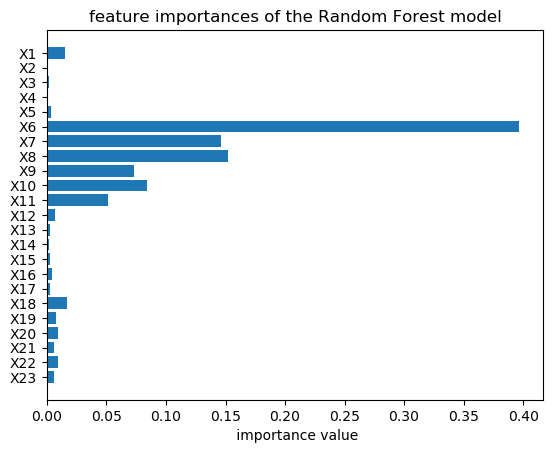

In [67]:
q = psrf.featureImportances
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
h= feature_cols 
y_pos = np.arange(len(q))
performance = q

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(h)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel(' importance value')
ax.set_title('feature importances of the Random Forest model')

Perform predictions on both training dataframe and testing dataframe.


In [68]:
p_test = psrf.transform(test_df)
p_train = psrf.transform(train_df)
p_test.select("prediction", "labelRandomForest").show(10)
p_train.select("prediction","labelRandomForest").show(10)


+----------+-----------------+
|prediction|labelRandomForest|
+----------+-----------------+
|       0.0|                0|
|       0.0|                0|
|       0.0|                0|
|       0.0|                0|
|       0.0|                0|
|       0.0|                0|
|       0.0|                0|
|       0.0|                0|
|       0.0|                1|
|       0.0|                0|
+----------+-----------------+
only showing top 10 rows

+----------+-----------------+
|prediction|labelRandomForest|
+----------+-----------------+
|       0.0|                1|
|       0.0|                1|
|       0.0|                0|
|       1.0|                0|
|       0.0|                0|
|       0.0|                0|
|       0.0|                1|
|       0.0|                0|
|       1.0|                1|
|       0.0|                1|
+----------+-----------------+
only showing top 10 rows



**Validation**: Evaluation metrics of model training result.


In [69]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
metrix_st=[]
a_st=[]
m_in=[]
a_in=[]
for i in ["accuracy", "f1", "weightedPrecision", "weightedRecall"]:
    metrix_st = MulticlassClassificationEvaluator(labelCol="labelRandomForest", predictionCol="prediction", metricName=i)
    a_st = metrix_st.evaluate(p_test)
    metrix_in = MulticlassClassificationEvaluator(labelCol="labelRandomForest", predictionCol="prediction", metricName=i)
    a_in = metrix_in.evaluate(p_train)
    print("The",i,"of test data is", a_st,". The",i,"of train data is", a_in)
    

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

The accuracy of test data is 0.8233613445378152 . The accuracy of train data is 0.8223284823284823
The f1 of test data is 0.8013158289188232 . The f1 of train data is 0.7991659398656931
The weightedPrecision of test data is 0.8059550563985469 . The weightedPrecision of train data is 0.8070414693632983
The weightedRecall of test data is 0.8233613445378152 . The weightedRecall of train data is 0.8223284823284823


In [70]:
psrf.write().overwrite().save("random_forest_pyspark")
spark.stop()

### Summary
The most important features of the random
forest model are:

- All past monthly payment record,
especially September 2005 one.

- Amount of given credit

- All amount of previous payment.

The accuracy of test data is 0.823 . The
accuracy of train data is 0.823. The f1 of test
data is 0.800. The f1 of train data is 0.799.
The weighted precision of test data is 0.805.
The weighted precision of train data is 0.808.

## Model 3: K means clustering 

Load package and data set

In [71]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

credit_data = pd.read_csv('./data.csv')
label_colm= 'Y'

# check for missing value
credit_data.isna().sum()

X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
Y      0
dtype: int64

In [72]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split
s = ['Y']
X, Y = credit_data.drop(['Y'], axis=1), credit_data[s]

X_train, X_test, y_train, y_test = \
    train_test_split(X, Y, test_size=0.25, random_state=50)

Use SK learn standardscalar to train a scaler on X_train. Using the scaler, scale X_train, X_test to X_train_scaled and X_test_scaled. 


In [73]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_fit = sc.fit(X_train)
X_train_scaled =X_train_fit .transform(X_train)
X_test_scaled= X_train_fit .transform(X_test)


Train a Kmeans cluster on X_train_scaled. From now on, I will only work with scaled training and test data. Set number of clusters to 5 and do a parallel plot to see the cluster centers.


In [74]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

def compute_WSSE(X, model):
    '''
    Write your code below
    '''
    
    Center = model.cluster_centers_
    z=model.labels_
    unique_elements, counts_elements = np.unique(z, return_counts=True)
    counts = counts_elements
    
    CMn=[]
    Xn=[]
    dn = []
    for i in unique_elements:
        CMnn = np.array([Center[i],]*counts[i])
        CMn.append(CMnn)
        Xnn = X[ClusterIndicesNumpy(i, model.labels_)]
        Xn.append(Xnn)
        dnn = np.linalg.norm(Xn[i]- CMn[i])
        dn.append(dnn)
    dnp = np.asarray(dn)
    wsse = sum(dnp**2)
    return wsse


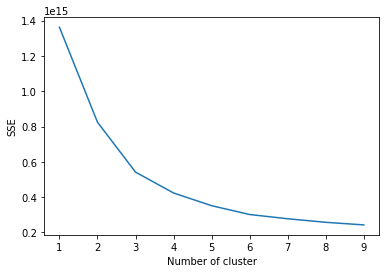

In [75]:

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(credit_data)
    credit_data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

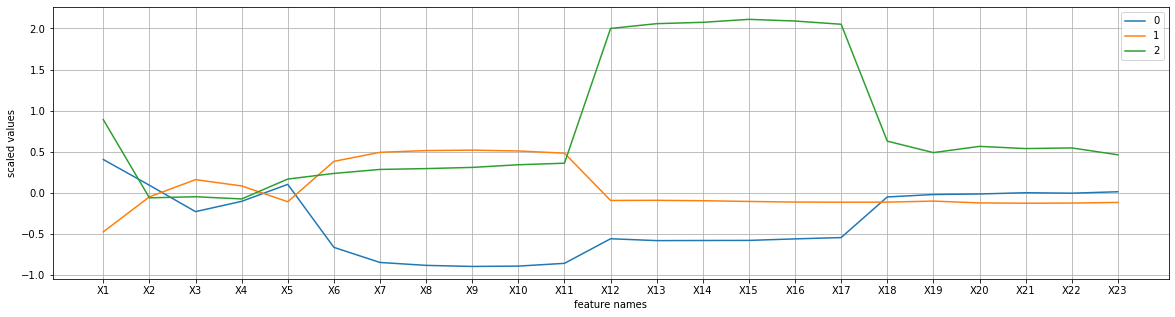

In [76]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=40) 
kmeans.fit(X_train_scaled)
cc =kmeans.cluster_centers_
cc.shape
l =kmeans.labels_
feats = X_train.columns
plt.figure(figsize=(20,5))
c1 = cc[0,:]
c2 = cc[1,:]
c3 = cc[2,:]

plt.plot(feats, c1)
plt.plot(feats, c2)
plt.plot(feats, c3)

plt.grid(True)
plt.legend([0,1,2])
plt.xlabel("feature names")
plt.ylabel("scaled values")
plt.show()

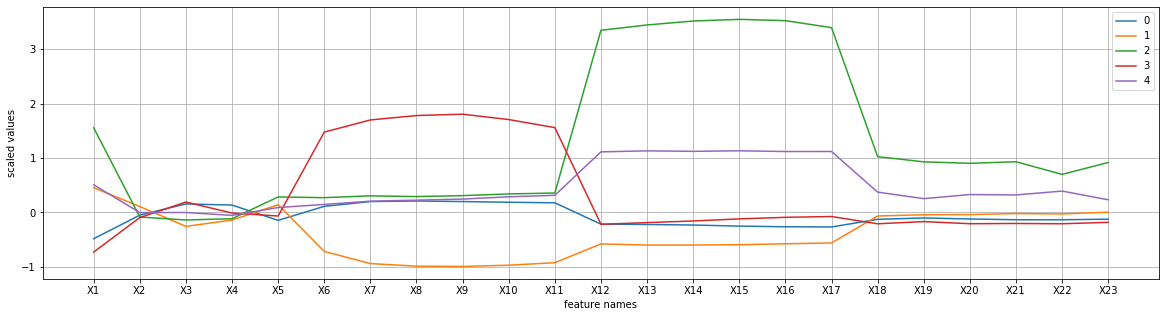

In [77]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=40) 
kmeans.fit(X_train_scaled)
cc =kmeans.cluster_centers_
cc.shape
l =kmeans.labels_
feats = X_train.columns
plt.figure(figsize=(20,5))
c1 = cc[0,:]
c2 = cc[1,:]
c3 = cc[2,:]
c4 = cc[3,:]
c5 = cc[4,:]
plt.plot(feats, c1)
plt.plot(feats, c2)
plt.plot(feats, c3)
plt.plot(feats, c4)
plt.plot(feats, c5)
plt.grid(True)
plt.legend([0,1,2,3,4])
plt.xlabel("feature names")
plt.ylabel("scaled values")
plt.show()


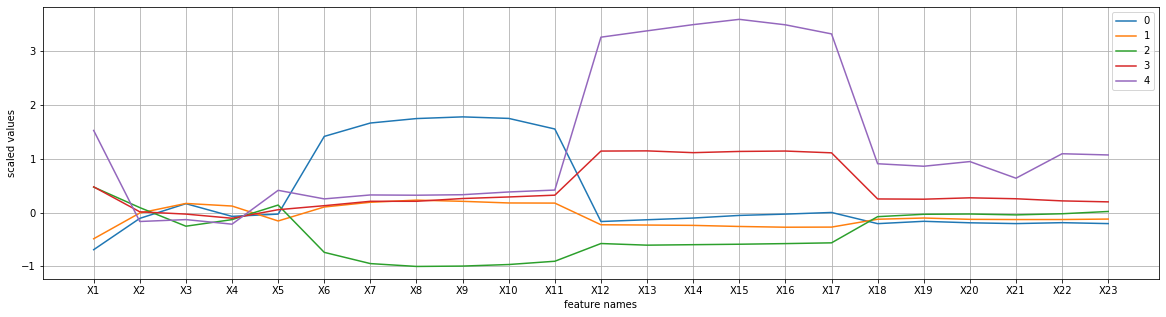

In [78]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=40) 
kmean1 = kmeans.fit(X_test_scaled)
cc =kmeans.cluster_centers_
cc.shape
l =kmeans.labels_
feats = X_train.columns
plt.figure(figsize=(20,5))
c1 = cc[0,:]
c2 = cc[1,:]
c3 = cc[2,:]
c4 = cc[3,:]
c5 = cc[4,:]
plt.plot(feats, c1)
plt.plot(feats, c2)
plt.plot(feats, c3)
plt.plot(feats, c4)
plt.plot(feats, c5)
plt.grid(True)
plt.legend([0,1,2,3,4])
plt.xlabel("feature names")
plt.ylabel("scaled values")
plt.show()

Show the training data default rate with each cluster. 


In [79]:
import statistics
preds = kmeans.predict(X_train_scaled)
y_train['cluster']=preds
coi = [0,1,2,3,4]
for i in coi:
    m= y_train['cluster'].isin([i])
    n=y_train[m]
    z= statistics.mean(n['Y'])
    print(z)

0.6251748251748251
0.19798369798369797
0.1658878504672897
0.1599645180366647
0.21348314606741572


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Use PySpark to perform random forest classification, evaluation and hyperparameter tuning


In [80]:
predss = kmeans.predict(X_test_scaled)

y_test['cluster']=predss
coi = [0,1,2,3,4]
for i in coi:
    m= y_test['cluster'].isin([i])
    n=y_test[m]
    z= statistics.mean(n['Y'])
    print(z)

0.6304347826086957
0.18935483870967743
0.15384615384615385
0.14601769911504425
0.225


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
from joblib import dump,load

dump(kmeans,'kmeans1')



['kmeans1']

High-default customers share the pattern of having a relatively high
repayment status, and a relative low amount of given credit.